## 11.1基本的采样方法

在预测分布中，后验概率组要用于计算期望，我们希望找到某个函数$f(z)$关于一个概率分布$p(z)$的期望
$$\mathbb E[f]=\int f(z)p(z)dz$$
简单来说采样方法就是得到概率分布$p(z)$中独立抽取的一组变量$z$,其中$l=1,...L$,这样期望就可以通过有限和的方式得到:
$$\hat f=\frac{1}{L}\sum_{l=1}^Lf(z^{(l)})$$
只要样本$z^{(l)}$是从$p(z)$中抽取的，那么$\mathbb E[\hat f]=\mathbb E[f]$,因此估计$\hat f$有正确的均值，方差就为
$$vat[\hat f]=\frac{1}{L}\mathbb E[f-\mathbb E[f])^2]$$

最早的蒙特卡罗方法是为了求解一些积分问题

In [2]:
import sys
#sys.path
sys.path.append(r"../")
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from prml.rv import Gaussian, Uniform
from prml.sampling import metropolis, metropolis_hastings, rejection_sampling, sir

np.random.seed(666)

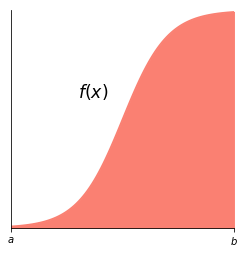

In [3]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))
x=np.linspace(-5,5,100)
y=sigmoid(x)

fig, ax = plt.subplots(figsize=(4, 4))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xticks([-5,5])
ax.set_xticklabels(['$a$','$b$'])
ax.set_yticks([])
ax.plot(x,y,color="salmon")
ax.fill_between(x,y,color="salmon")
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.text(-2, 0.6, "$f(x)$", fontsize="xx-large")


则一个简单的近似求解方法是在[a,b]之间随机的采样一个点。比如 $x_{0}$ ，然后用 $f(x_{0})$ 代表在[a,b]区间上所有的 $f(x)$ 的值。那么上面的定积分的近似求解为:
$$(b-a)f(x_{0})$$
推广开来，我们可以采样[a,b]区间的n个值： $x_{0}，x_{1},...,x_{n-1}$ ，用它们的均值来代表$[a,b]$区间上所有的 $f(x)$ 的值。这样我们上面的定积分的近似求解为:
$$\frac{b-a}{n}\sum_{n=0}^{n-1}f(x_i)$$

但是绝大部分情况下x在区间$[a,b]$的分布不是均匀分布，如果假设x的分布为$p(x)$则：
$$\int_a^bf(x)dx=\int_a^b\frac{f(x)}{p(x)}p(x)\simeq\frac{1}{n}\sum_{n=0}^{n-1}\frac{f(x_i)}{p(x_i)}$$
代入均匀分布页可以得到前面的结果

现在考虑如何从简单的分均匀分布产生随机数，我们使用一个函数$y=f(z)$来对z服从的$（0,1）$均匀分布变换
$$p(y)=p(z)|\frac{dz}{dy}|$$
$$z=h(y)\equiv\int_{-\infty}^yp(\hat y)d\hat y$$
常用的函数包括
$$p(y)=\lambda exp(-\lambda y)$$
$$p(y)=\frac{1}{\pi}\frac{1}{1+y^2}$$

例子:使用Box-muller方法用于生成高斯分布的样本

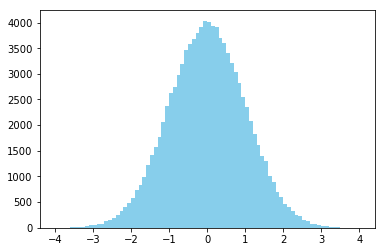

In [4]:
def getNormal(SampleSize):
    iid = np.random.uniform(0,1,SampleSize)
    normal1 = np.cos(2*np.pi*iid[0:int(SampleSize/2-1)])*np.sqrt(-2*np.log(iid[int(SampleSize/2):SampleSize-1]))
    normal2 = np.sin(2*np.pi*iid[0:int(SampleSize/2-1)])*np.sqrt(-2*np.log(iid[int(SampleSize/2):SampleSize-1]))
    return np.hstack((normal1,normal2))
SampleSize = 100000
normal = getNormal(SampleSize)
plt.hist(normal,np.linspace(-4,4,81),histtype='bar',facecolor="skyblue")
plt.show()


### 11.1.2拒绝采样

设定一个程序可采样的分布 $q(x)$ 比如高斯分布，然后按照一定的方法拒绝某些样本，以达到接近 $p(x)$ 分布的目的，其中$q(x)$叫做 proposal distribution。

具体算法如下：
* 引入一个常数k
* 从概率分布$q(z)$中产生一个数$z_0$
* 在区间$[0,kq(z_0)]$上的均匀分布生成一个数$\mu_0$
* 如果$\mu_0>\tilde p(z_0)$则样本被拒绝

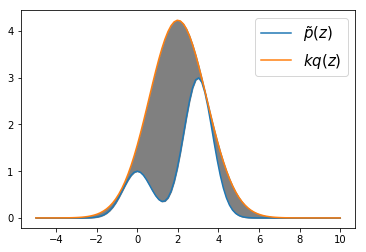

In [5]:
def func(x):
    return np.exp(-x ** 2) + 3 * np.exp(-(x - 3) ** 2)
x = np.linspace(-5, 10, 100)
#提议分布
rv = Gaussian(mu=np.array([2.]), var=np.array([2.]))
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.plot(x, 15 * rv.pdf(x), label=r"$kq(z)$")
plt.fill_between(x, func(x), 15 * rv.pdf(x), color="gray")
plt.legend(fontsize=15)
plt.show()

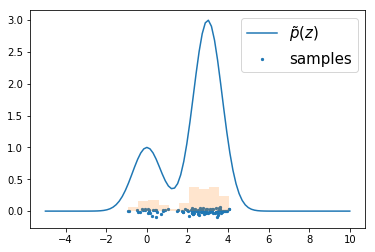

In [6]:
samples = rejection_sampling(func, rv, k=15, n=100)
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, normed=True, alpha=0.2)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=15)
plt.show()

### 11.1.5重要性采样

回到期望的计算，我们考虑:
$$\begin{align}\mathbb E[f]&=\int f(z)p(z)dz\\&=\int f(z)\frac{p(z)}{q(z)}q(z)dz\\&=\frac{1}{L}\sum_{l=1}^L\frac{p(z^{(l)})}{q(z^{(l)})}f(z^{(l)})\end{align}$$

$r_l=\frac{p(z^{(l)})}{q(z^{(l)})}$为重要性权重，修正了由于从错误的概率分布中采样引⼊
的偏差。注意，与拒绝采样不同，所有⽣成的样本都被保留。
* L个样本$z^{(l)},...,z^{(L)}$从$q(z)$中抽取
* 计算权值 $$w_l=\frac{\tilde r_l}{\sum_m\tilde r_m}$$

* L个样本的第二个集合从离散概率分布$z^{(l)},...,z^{(L)}$中抽取，概率由权值$(w_1,...,w_L)$给定

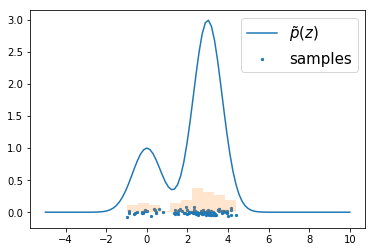

In [9]:
samples = sir(func, rv, n=100)
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, normed=True, alpha=0.2)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=15)
plt.show()